In [ ]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import xgboost as xgb
from sklearn.metrics import accuracy_score

## **Feature Engineering**: Patients Data Table

In [ ]:
pat_df = pd.read_csv('PATIENTS.csv')
pat_df.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


In [ ]:
# Convert DOB and DOD to datetime type
pat_df['DOB'] = pd.to_datetime(pat_df['DOB'])
pat_df['DOD'] = pd.to_datetime(pat_df['DOD'])

pat_df['AGE'] = pat_df['DOD'].dt.year - pat_df['DOB'].dt.year
pat_df.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,AGE
0,234,249,F,2075-03-13,NaT,NaN,NaN,0,NaN
1,235,250,F,2164-12-27,2188-11-22,2188-11-22 00:00:00,NaN,1,24.0
2,236,251,M,2090-03-15,NaT,NaN,NaN,0,NaN
3,237,252,M,2078-03-06,NaT,NaN,NaN,0,NaN
4,238,253,F,2089-11-26,NaT,NaN,NaN,0,NaN


In [ ]:
pat_df['EXPIRE_FLAG'].value_counts()

,count
EXPIRE_FLAG,
0,30761
1,15759


In [ ]:
pat_df['AGE'] = pat_df['AGE'].fillna(pat_df['AGE'].median())

In [ ]:
pat_df['AGE'].describe()

,AGE
count,46520.000000
mean,81.408835
std,40.806170
min,0.000000
25%,76.000000
50%,76.000000
75%,76.000000
max,311.000000


In [ ]:
mean_age = pat_df['AGE'].mean()
median_age = pat_df['AGE'].median()

print(mean_age)
print(median_age)

81.40883490971625
76.0


In [ ]:
pat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46520 entries, 0 to 46519
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ROW_ID       46520 non-null  int64         
 1   SUBJECT_ID   46520 non-null  int64         
 2   GENDER       46520 non-null  object        
 3   DOB          46520 non-null  datetime64[ns]
 4   DOD          15759 non-null  datetime64[ns]
 5   DOD_HOSP     9974 non-null   object        
 6   DOD_SSN      13378 non-null  object        
 7   EXPIRE_FLAG  46520 non-null  int64         
 8   AGE          46520 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(3), object(3)
memory usage: 3.2+ MB


In [ ]:
pat_df = pat_df[pat_df['AGE'] < 100]

In [ ]:
pat_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45040 entries, 0 to 46519
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ROW_ID       45040 non-null  int64         
 1   SUBJECT_ID   45040 non-null  int64         
 2   GENDER       45040 non-null  object        
 3   DOB          45040 non-null  datetime64[ns]
 4   DOD          14279 non-null  datetime64[ns]
 5   DOD_HOSP     9081 non-null   object        
 6   DOD_SSN      12117 non-null  object        
 7   EXPIRE_FLAG  45040 non-null  int64         
 8   AGE          45040 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(3), object(3)
memory usage: 3.4+ MB


In [ ]:
pat_df['AGE'].astype(int)

,AGE
0,76
1,24
2,76
3,76
4,76
...,...
46515,76
46516,76
46517,86
46518,76


In [ ]:
# Drop columns that are not needed anymore
pat_df = pat_df.drop(['ROW_ID', 'DOD', 'DOB', 'DOD_HOSP', 'DOD_SSN'], axis=1)
pat_df.head()

,SUBJECT_ID,GENDER,EXPIRE_FLAG,AGE
0,249,F,0,76.0
1,250,F,1,24.0
2,251,M,0,76.0
3,252,M,0,76.0
4,253,F,0,76.0


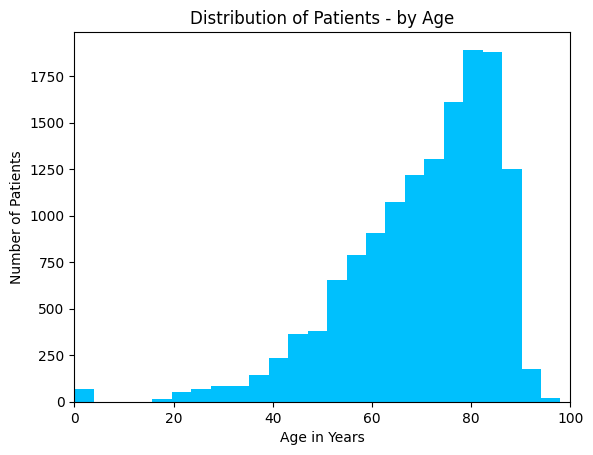

In [ ]:
# Plot overall AGE Distribution
plt.hist(pat_df[pat_df['EXPIRE_FLAG'] == 1]['AGE'], bins=25, color = '#00c0fd')
plt.xlim(0, 100)
plt.title('Distribution of Patients - by Age')
plt.ylabel('Number of Patients')
plt.xlabel('Age in Years')
plt.tick_params(top=False, right=False)
plt.show();

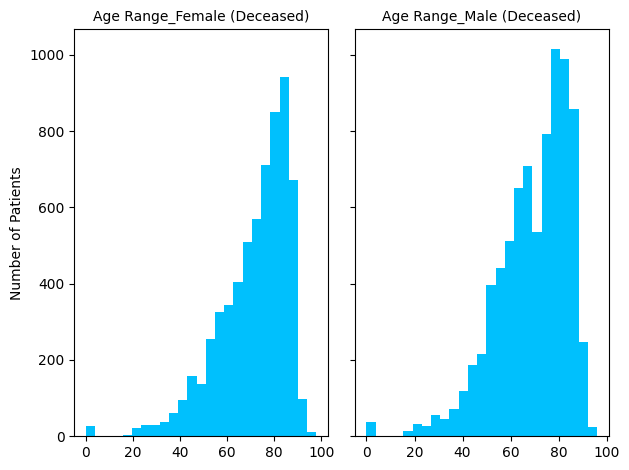

In [ ]:
# Generate two distributions by gender type
distF = pat_df['AGE'].loc[(pat_df['GENDER'] == 'F') & (pat_df['EXPIRE_FLAG'] == 1)]
distM = pat_df['AGE'].loc[(pat_df['GENDER'] == 'M') & (pat_df['EXPIRE_FLAG'] == 1)]

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(distF, bins=25, color='#00c0fd')
axs[1].hist(distM, bins=25, color='#00c0fd')

axs[0].set_title('Age Range_Female (Deceased)', fontsize = 10)
axs[1].set_title('Age Range_Male (Deceased)', fontsize = 10)
axs[0].set_ylabel('Number of Patients', fontsize = 10)

plt.show()

In [ ]:
mean_deceased_age = pat_df[pat_df['EXPIRE_FLAG'] == 1]['AGE'].mean()
median_deceased_age = pat_df[pat_df['EXPIRE_FLAG'] == 1]['AGE'].median()

print(mean_deceased_age)
print(median_deceased_age)

70.27592968695286
74.0


In [ ]:
mean_age_F = pat_df[pat_df['EXPIRE_FLAG'] == 1]['AGE'].loc[pat_df['GENDER'] == 'F'].mean()
median_age_F = pat_df[pat_df['EXPIRE_FLAG'] == 1]['AGE'].loc[pat_df['GENDER'] == 'F'].median()

mean_age_M = pat_df[pat_df['EXPIRE_FLAG'] == 1]['AGE'].loc[pat_df['GENDER'] == 'M'].mean()
median_age_M = pat_df[pat_df['EXPIRE_FLAG'] == 1]['AGE'].loc[pat_df['GENDER'] == 'M'].median()


print('Mean age is {} for Deceased Female patients.'.format((mean_age_F)))
print('Median age is {} for Deceased Female patients.'.format(median_age_F))

print('Mean age is {} for Deceased Male patients.'.format((mean_age_M)))
print('Median age is {} for Deceased Male patients.'.format(median_age_M))

Mean age is 71.55645545497856 for Deceased Female patients.
Median age is 75.0 for Deceased Female patients.
Mean age is 69.26572287647207 for Deceased Male patients.
Median age is 72.0 for Deceased Male patients.


In [ ]:
mean_age = pat_df['AGE'].mean()
median_age = pat_df['AGE'].median()

print(mean_age)
print(median_age)

74.18530195381882
76.0


## **Feature Engineering**: Admission Data Table

In [ ]:
adm_df = pd.read_csv('ADMISSIONS.csv')
adm_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [ ]:
adm_df['HOSPITAL_EXPIRE_FLAG'].value_counts()

,count
HOSPITAL_EXPIRE_FLAG,
0,53122
1,5854


In [ ]:
# Convert admit & discharge times to datatime type
adm_df['ADMITTIME'] = pd.to_datetime(adm_df['ADMITTIME'])
adm_df['DISCHTIME'] = pd.to_datetime(adm_df['DISCHTIME'])

In [ ]:
# Check if deceased patients have admit and discharge time
adm_df[['ADMITTIME', 'DISCHTIME', 'HOSPITAL_EXPIRE_FLAG']].loc[adm_df['HOSPITAL_EXPIRE_FLAG'] == 1].head()

,ADMITTIME,DISCHTIME,HOSPITAL_EXPIRE_FLAG
9,2108-08-22 23:27:00,2108-08-30 15:00:00,1
57,2104-01-02 02:01:00,2104-01-08 10:30:00,1
63,2119-01-04 18:12:00,2119-02-03 01:35:00,1
70,2157-12-02 00:45:00,2157-12-02 03:55:00,1
88,2196-04-14 04:02:00,2196-04-17 13:42:00,1


In [ ]:
# Convert length of stays in days based on time in seconds (60*60*24 = 86400)
adm_df['LOS_HOSP'] = (adm_df['DISCHTIME'] - adm_df['ADMITTIME']).dt.total_seconds()/86400
adm_df['LOS_HOSP'].describe()

,LOS_HOSP
count,58976.000000
mean,10.133916
std,12.456682
min,-0.945139
25%,3.743750
50%,6.467014
75%,11.795139
max,294.660417


In [ ]:
#adm_df = adm_df[adm_df['HOSPITAL_EXPIRE_FLAG'] == 1]
adm_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,LOS_HOSP
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,1.144444
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,5.496528
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1,6.768056
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1,2.856944
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1,3.534028


In [ ]:
adm_df['HOSPITAL_EXPIRE_FLAG'].value_counts()

,count
HOSPITAL_EXPIRE_FLAG,
0,53122
1,5854


In [ ]:
# Convert length of stays in days based on time in seconds (60*60*24 = 86400) - after including only deceased patients
adm_df['LOS_HOSP'].describe()

,LOS_HOSP
count,58976.000000
mean,10.133916
std,12.456682
min,-0.945139
25%,3.743750
50%,6.467014
75%,11.795139
max,294.660417


In [ ]:
adm_df = adm_df[(adm_df['LOS_HOSP'] > 0)]
adm_df['LOS_HOSP'].describe()

,LOS_HOSP
count,58878.000000
mean,10.151266
std,12.459774
min,0.001389
25%,3.755556
50%,6.489583
75%,11.805556
max,294.660417


In [ ]:
# Drop the columns that are not needed
adm_df.drop(columns=['ADMITTIME',	'DISCHTIME', 'ROW_ID',
                'EDREGTIME', 'EDOUTTIME', 'DEATHTIME',
                'HAS_CHARTEVENTS_DATA', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'DIAGNOSIS'], inplace=True)
adm_df.head()

<ipython-input-27-35fe1a0e1be3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adm_df.drop(columns=['ADMITTIME',	'DISCHTIME', 'ROW_ID',


,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,HOSPITAL_EXPIRE_FLAG,LOS_HOSP
0,22,165315,EMERGENCY,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,0,1.144444
1,23,152223,ELECTIVE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,0,5.496528
2,23,124321,EMERGENCY,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,0,6.768056
3,24,161859,EMERGENCY,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,0,2.856944
4,25,129635,EMERGENCY,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,0,3.534028


In [ ]:
adm_df['ETHNICITY'].value_counts()

,count
ETHNICITY,
WHITE,40939
BLACK/AFRICAN AMERICAN,5434
UNKNOWN/NOT SPECIFIED,4502
HISPANIC OR LATINO,1693
ASIAN,1508
OTHER,1507
UNABLE TO OBTAIN,809
PATIENT DECLINED TO ANSWER,559
ASIAN - CHINESE,277


In [ ]:
# Grouping the Ethnicity column by certain group/categories
adm_df['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
adm_df['ETHNICITY'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
adm_df['ETHNICITY'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
adm_df['ETHNICITY'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
adm_df['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER',
                         'UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', inplace=True)
adm_df['ETHNICITY'].loc[~adm_df['ETHNICITY'].isin(adm_df['ETHNICITY'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'
adm_df['ETHNICITY'].value_counts()

<ipython-input-29-638c4be5457e>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  adm_df['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
<ipython-input-29-638c4be5457e>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

,count
ETHNICITY,
WHITE,41268
OTHER/UNKNOWN,7700
BLACK/AFRICAN AMERICAN,5779
HISPANIC/LATINO,2125
ASIAN,2006


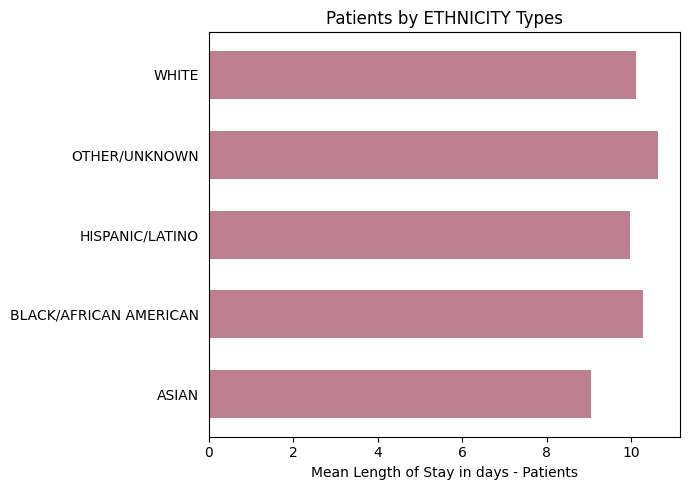

In [ ]:
# Plotting function
def plot_los_groupby(variable, size=(7,5)):

    results =  adm_df[[variable, 'LOS_HOSP']].groupby(variable).mean().reset_index()
    values = list(results['LOS_HOSP'].values)
    labels = list(results[variable].values)

    fig, ax = plt.subplots(figsize=size)
    ind = range(len(results))
    ax.barh(ind, values, align='center', height=0.6, color = '#a8556c', alpha=0.75)
    ax.set_yticks(ind)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Mean Length of Stay in days - Patients')
    ax.tick_params(left=False, top=False, right=False)
    ax.set_title('Patients by {} Types'.format(variable))

    plt.tight_layout()
    plt.show();


plot_los_groupby('ETHNICITY', size=(7,5))


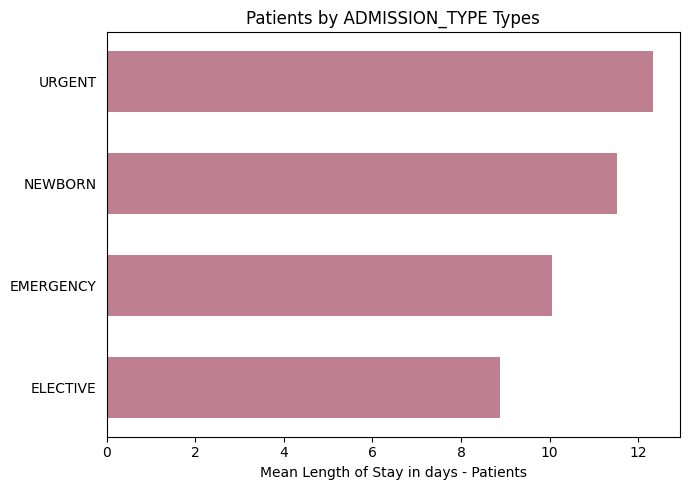

In [ ]:
plot_los_groupby('ADMISSION_TYPE', size=(7,5))

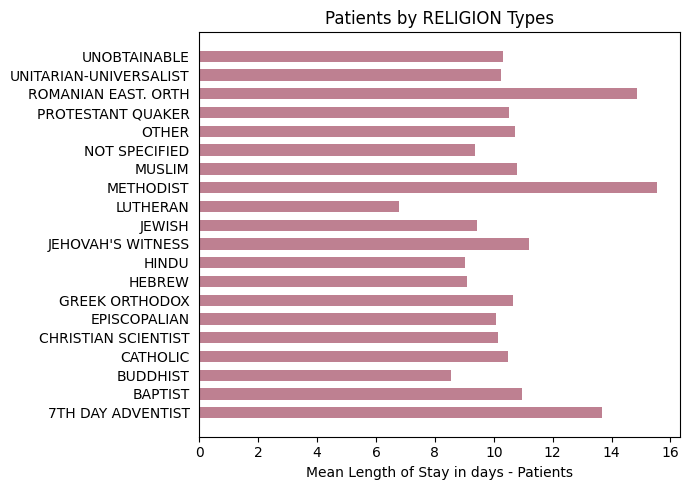

In [ ]:
plot_los_groupby('RELIGION', size=(7,5))

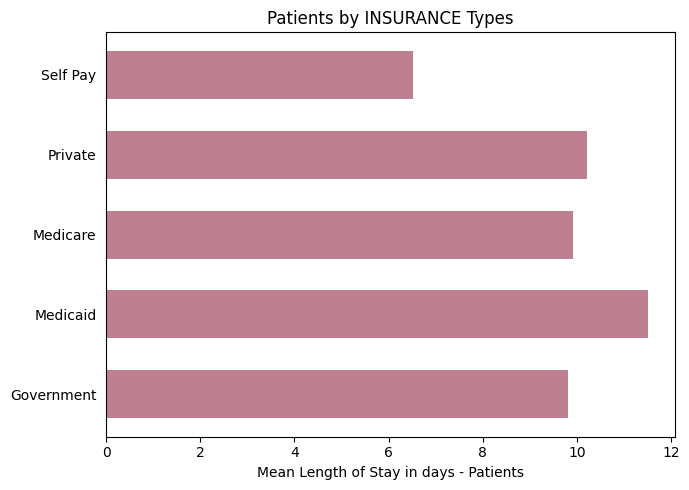

In [ ]:
plot_los_groupby('INSURANCE', size=(7,5))

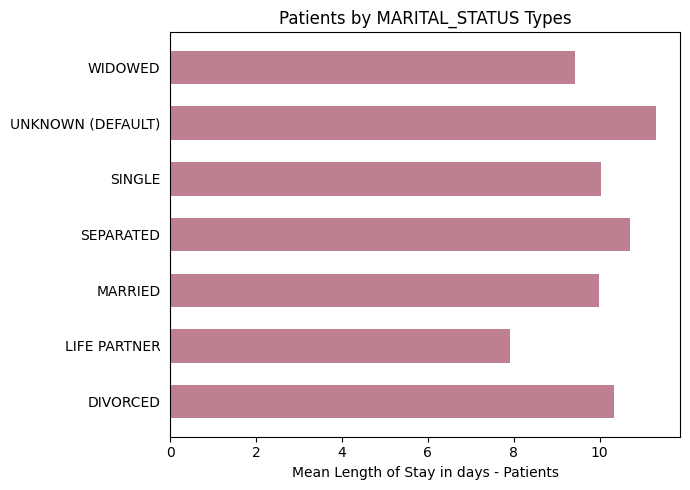

In [ ]:
plot_los_groupby('MARITAL_STATUS', size=(7,5))

In [ ]:
print('Final Admission table output data has {} number of unique admission events.'.format(adm_df['HADM_ID'].nunique()))
print('Final Admission table output data has {} number of unique patients.'.format(adm_df['SUBJECT_ID'].nunique()))

Final Admission table output data has 58878 number of unique admission events.
Final Admission table output data has 46445 number of unique patients.


## **Feature Engineering**: ICUSTAYS Data Table

In [ ]:
icu_df = pd.read_csv('ICUSTAYS.csv')
icu_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.2788
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,2.8939
3,368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0600
4,369,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,1.6202


In [ ]:
icu_df['LOS'].describe()

,LOS
count,61522.000000
mean,4.917972
std,9.638784
min,0.000100
25%,1.108025
50%,2.092250
75%,4.483175
max,173.072500


In [ ]:
icu_df = icu_df.drop(['ROW_ID', 'INTIME', 'DBSOURCE', 'OUTTIME', 'FIRST_WARDID', 'LAST_WARDID'], axis=1)
icu_df.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,FIRST_CAREUNIT,LAST_CAREUNIT,LOS
0,268,110404,280836,MICU,MICU,3.2490
1,269,106296,206613,MICU,MICU,3.2788
2,270,188028,220345,CCU,CCU,2.8939
3,271,173727,249196,MICU,SICU,2.0600
4,272,164716,210407,CCU,CCU,1.6202


In [ ]:
icu_df['LOS'].groupby(icu_df['FIRST_CAREUNIT']).mean()

,LOS
FIRST_CAREUNIT,
CCU,3.901562
CSRU,3.900016
MICU,4.012769
NICU,10.025806
SICU,4.706723
TSICU,4.443861


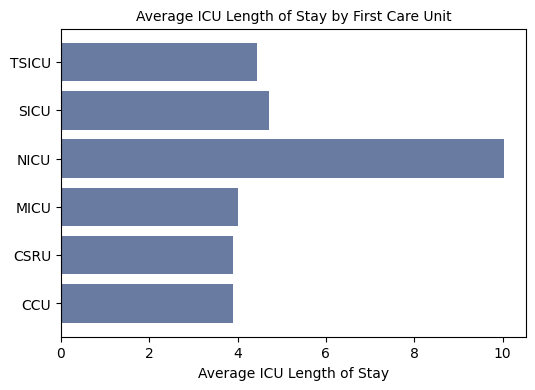

In [ ]:
fig, axs = plt.subplots(figsize=(6,4))

tick_positions = range(len(icu_df['FIRST_CAREUNIT'].unique()))
data = icu_df.groupby('FIRST_CAREUNIT')['LOS'].mean()
sorted_labels = sorted(icu_df['FIRST_CAREUNIT'].unique(), reverse=False)

axs.barh(tick_positions, data, align='center', color = '#6a7ba2')

axs.set_yticks(tick_positions, labels=sorted_labels)

axs.set_xlabel('Average ICU Length of Stay', fontsize = 10)  # Update x-axis label
axs.set_title('Average ICU Length of Stay by First Care Unit', fontsize = 10) # Update plot title
plt.show()


In [ ]:
icu_df['LOS'].groupby(icu_df['LAST_CAREUNIT']).mean()

,LOS
LAST_CAREUNIT,
CCU,3.446285
CSRU,3.874493
MICU,4.122262
NICU,10.025806
SICU,5.044084
TSICU,4.124977


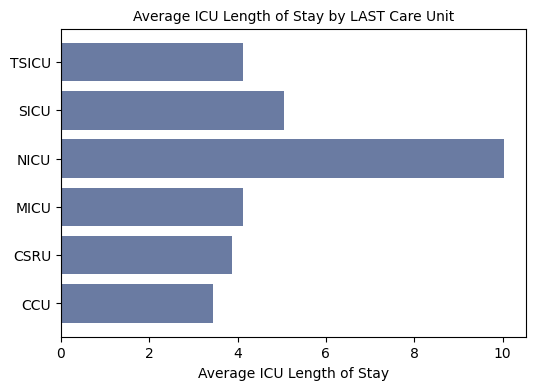

In [ ]:
fig, axs = plt.subplots(figsize=(6,4))

tick_positions = range(len(icu_df['LAST_CAREUNIT'].unique()))
data = icu_df.groupby('LAST_CAREUNIT')['LOS'].mean()
sorted_labels = sorted(icu_df['LAST_CAREUNIT'].unique(), reverse=False)

axs.barh(tick_positions, data, align='center', color = '#6a7ba2')

axs.set_yticks(tick_positions, labels=sorted_labels)

axs.set_xlabel('Average ICU Length of Stay', fontsize = 10)  # Update x-axis label
axs.set_title('Average ICU Length of Stay by LAST Care Unit', fontsize = 10) # Update plot title
plt.show()

In [ ]:
icu_df.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,FIRST_CAREUNIT,LAST_CAREUNIT,LOS
0,268,110404,280836,MICU,MICU,3.2490
1,269,106296,206613,MICU,MICU,3.2788
2,270,188028,220345,CCU,CCU,2.8939
3,271,173727,249196,MICU,SICU,2.0600
4,272,164716,210407,CCU,CCU,1.6202


In [ ]:
icu_df['LOS_ICU'] = icu_df['LOS']
icu_df = icu_df.drop(['LOS'], axis=1)
icu_df.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,FIRST_CAREUNIT,LAST_CAREUNIT,LOS_ICU
0,268,110404,280836,MICU,MICU,3.2490
1,269,106296,206613,MICU,MICU,3.2788
2,270,188028,220345,CCU,CCU,2.8939
3,271,173727,249196,MICU,SICU,2.0600
4,272,164716,210407,CCU,CCU,1.6202


## **Data Processing**: Join Tables and Data Wrangling

In [ ]:
# Merge all 3 data table outputs (Patients, Admissions & ICU_Stays) in one dataset

df_pat_adm = pd.merge(pat_df, adm_df, on='SUBJECT_ID')
#df = pd.merge(df, icu_df, on='HADM_ID')
df_pat_adm.head()

,SUBJECT_ID,GENDER,EXPIRE_FLAG,AGE,HADM_ID,ADMISSION_TYPE,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,HOSPITAL_EXPIRE_FLAG,LOS_HOSP
0,249,F,0,76.0,116935,EMERGENCY,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,0,13.759722
1,249,F,0,76.0,149546,EMERGENCY,Medicare,ENGL,CATHOLIC,DIVORCED,WHITE,0,10.624306
2,249,F,0,76.0,158975,EMERGENCY,Medicare,ENGL,CATHOLIC,DIVORCED,WHITE,0,16.997917
3,250,F,1,24.0,124271,EMERGENCY,Self Pay,HAIT,NOT SPECIFIED,SINGLE,BLACK/AFRICAN AMERICAN,1,10.109722
4,251,M,0,76.0,117937,EMERGENCY,Private,NaN,OTHER,NaN,OTHER/UNKNOWN,0,2.359028


In [ ]:
df_pat_adm_icu = pd.merge(df_pat_adm, icu_df, on='SUBJECT_ID' and 'HADM_ID')
df_pat_adm_icu.head()

,SUBJECT_ID_x,GENDER,EXPIRE_FLAG,AGE,HADM_ID,ADMISSION_TYPE,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,HOSPITAL_EXPIRE_FLAG,LOS_HOSP,SUBJECT_ID_y,ICUSTAY_ID,FIRST_CAREUNIT,LAST_CAREUNIT,LOS_ICU
0,249,F,0,76.0,116935,EMERGENCY,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,0,13.759722,249,215044,TSICU,MICU,5.7262
1,249,F,0,76.0,149546,EMERGENCY,Medicare,ENGL,CATHOLIC,DIVORCED,WHITE,0,10.624306,249,269035,MICU,MICU,1.9282
2,249,F,0,76.0,149546,EMERGENCY,Medicare,ENGL,CATHOLIC,DIVORCED,WHITE,0,10.624306,249,263055,TSICU,TSICU,3.8815
3,249,F,0,76.0,158975,EMERGENCY,Medicare,ENGL,CATHOLIC,DIVORCED,WHITE,0,16.997917,249,282599,MICU,MICU,2.0233
4,249,F,0,76.0,158975,EMERGENCY,Medicare,ENGL,CATHOLIC,DIVORCED,WHITE,0,16.997917,249,263882,MICU,MICU,1.0614


In [ ]:
df_pat_adm_icu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59380 entries, 0 to 59379
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SUBJECT_ID_x          59380 non-null  int64  
 1   GENDER                59380 non-null  object 
 2   EXPIRE_FLAG           59380 non-null  int64  
 3   AGE                   59380 non-null  float64
 4   HADM_ID               59380 non-null  int64  
 5   ADMISSION_TYPE        59380 non-null  object 
 6   INSURANCE             59380 non-null  object 
 7   LANGUAGE              34116 non-null  object 
 8   RELIGION              58923 non-null  object 
 9   MARITAL_STATUS        49284 non-null  object 
 10  ETHNICITY             59380 non-null  object 
 11  HOSPITAL_EXPIRE_FLAG  59380 non-null  int64  
 12  LOS_HOSP              59380 non-null  float64
 13  SUBJECT_ID_y          59380 non-null  int64  
 14  ICUSTAY_ID            59380 non-null  int64  
 15  FIRST_CAREUNIT     

In [ ]:
df_pat_adm_icu = df_pat_adm_icu.drop(['SUBJECT_ID_y','SUBJECT_ID_x', 'ICUSTAY_ID','EXPIRE_FLAG','LAST_CAREUNIT'], axis=1)
df_pat_adm_icu.head()

,GENDER,AGE,HADM_ID,ADMISSION_TYPE,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,HOSPITAL_EXPIRE_FLAG,LOS_HOSP,FIRST_CAREUNIT,LOS_ICU
0,F,76.0,116935,EMERGENCY,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,0,13.759722,TSICU,5.7262
1,F,76.0,149546,EMERGENCY,Medicare,ENGL,CATHOLIC,DIVORCED,WHITE,0,10.624306,MICU,1.9282
2,F,76.0,149546,EMERGENCY,Medicare,ENGL,CATHOLIC,DIVORCED,WHITE,0,10.624306,TSICU,3.8815
3,F,76.0,158975,EMERGENCY,Medicare,ENGL,CATHOLIC,DIVORCED,WHITE,0,16.997917,MICU,2.0233
4,F,76.0,158975,EMERGENCY,Medicare,ENGL,CATHOLIC,DIVORCED,WHITE,0,16.997917,MICU,1.0614


In [ ]:
df_pat_adm_icu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59380 entries, 0 to 59379
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   GENDER                59380 non-null  object 
 1   AGE                   59380 non-null  float64
 2   HADM_ID               59380 non-null  int64  
 3   ADMISSION_TYPE        59380 non-null  object 
 4   INSURANCE             59380 non-null  object 
 5   LANGUAGE              34116 non-null  object 
 6   RELIGION              58923 non-null  object 
 7   MARITAL_STATUS        49284 non-null  object 
 8   ETHNICITY             59380 non-null  object 
 9   HOSPITAL_EXPIRE_FLAG  59380 non-null  int64  
 10  LOS_HOSP              59380 non-null  float64
 11  FIRST_CAREUNIT        59380 non-null  object 
 12  LOS_ICU               59370 non-null  float64
dtypes: float64(3), int64(2), object(8)
memory usage: 5.9+ MB


In [ ]:
df_pat_adm_icu['FIRST_CAREUNIT'].replace({'CCU': 'ICU', 'CSRU': 'ICU', 'MICU': 'ICU','SICU': 'ICU', 'TSICU': 'ICU'}, inplace=True)

<ipython-input-50-9f381b024443>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pat_adm_icu['FIRST_CAREUNIT'].replace({'CCU': 'ICU', 'CSRU': 'ICU', 'MICU': 'ICU','SICU': 'ICU', 'TSICU': 'ICU'}, inplace=True)


In [ ]:
df_pat_adm_icu.head()

,GENDER,AGE,HADM_ID,ADMISSION_TYPE,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,HOSPITAL_EXPIRE_FLAG,LOS_HOSP,FIRST_CAREUNIT,LOS_ICU
0,F,76.0,116935,EMERGENCY,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,0,13.759722,ICU,5.7262
1,F,76.0,149546,EMERGENCY,Medicare,ENGL,CATHOLIC,DIVORCED,WHITE,0,10.624306,ICU,1.9282
2,F,76.0,149546,EMERGENCY,Medicare,ENGL,CATHOLIC,DIVORCED,WHITE,0,10.624306,ICU,3.8815
3,F,76.0,158975,EMERGENCY,Medicare,ENGL,CATHOLIC,DIVORCED,WHITE,0,16.997917,ICU,2.0233
4,F,76.0,158975,EMERGENCY,Medicare,ENGL,CATHOLIC,DIVORCED,WHITE,0,16.997917,ICU,1.0614


In [ ]:
df_pat_adm_icu.groupby(['FIRST_CAREUNIT','INSURANCE'])['LOS_ICU'].mean()

FIRST_CAREUNIT  INSURANCE 
ICU             Government     3.779482
                Medicaid       4.163864
                Medicare       4.282467
                Private        4.070170
                Self Pay       3.053780
NICU            Government     8.946560
                Medicaid      12.201980
                Medicare       0.140100
                Private        9.710483
                Self Pay       3.537483
Name: LOS_ICU, dtype: float64

In [ ]:
df_pat_adm_icu.groupby(['FIRST_CAREUNIT','ADMISSION_TYPE'])['LOS_ICU'].mean()

FIRST_CAREUNIT  ADMISSION_TYPE
ICU             ELECTIVE           3.493476
                EMERGENCY          4.254250
                URGENT             5.371893
NICU            ELECTIVE          27.233150
                EMERGENCY         15.552645
                NEWBORN            9.896224
                URGENT             8.894105
Name: LOS_ICU, dtype: float64

In [ ]:
df_pat_adm_icu.groupby('FIRST_CAREUNIT')['HADM_ID'].count()

,HADM_ID
FIRST_CAREUNIT,
ICU,51289
NICU,8091


In [ ]:
df_pat_adm_icu['CAREUNIT'] = df_pat_adm_icu['FIRST_CAREUNIT']
pat_adm_icu_list = df_pat_adm_icu.groupby('HADM_ID')['CAREUNIT'].apply(list).reset_index()
pat_adm_icu_list.head()

,HADM_ID,CAREUNIT
0,100001,[ICU]
1,100003,[ICU]
2,100006,[ICU]
3,100007,[ICU]
4,100009,[ICU]


In [ ]:
# Create ICU matrix
pat_adm_icu_item = pd.get_dummies(pat_adm_icu_list['CAREUNIT'].apply(pd.Series).stack()).groupby(level=0).sum()
pat_adm_icu_item[pat_adm_icu_item >= 1] = 1
pat_adm_icu_item = pat_adm_icu_item.join(pat_adm_icu_list['HADM_ID'], how="outer")
pat_adm_icu_item.head()

,ICU,NICU,HADM_ID
0,1,0,100001
1,1,0,100003
2,1,0,100006
3,1,0,100007
4,1,0,100009


In [ ]:
print("Hospital admissions to ICU {}.".format(pat_adm_icu_item.ICU.sum()))
print("Hospital admissions to NICU {}.".format(pat_adm_icu_item.NICU.sum()))

Hospital admissions to ICU 47765.
Hospital admissions to NICU 7983.


In [ ]:
# Merge data with the original dataset
df_pat_adm_icu = pd.merge(df_pat_adm_icu, pat_adm_icu_item, on='HADM_ID')
df_pat_adm_icu.head()

,GENDER,AGE,HADM_ID,ADMISSION_TYPE,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,HOSPITAL_EXPIRE_FLAG,LOS_HOSP,FIRST_CAREUNIT,LOS_ICU,CAREUNIT,ICU,NICU
0,F,76.0,116935,EMERGENCY,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,0,13.759722,ICU,5.7262,ICU,1,0
1,F,76.0,149546,EMERGENCY,Medicare,ENGL,CATHOLIC,DIVORCED,WHITE,0,10.624306,ICU,1.9282,ICU,1,0
2,F,76.0,149546,EMERGENCY,Medicare,ENGL,CATHOLIC,DIVORCED,WHITE,0,10.624306,ICU,3.8815,ICU,1,0
3,F,76.0,158975,EMERGENCY,Medicare,ENGL,CATHOLIC,DIVORCED,WHITE,0,16.997917,ICU,2.0233,ICU,1,0
4,F,76.0,158975,EMERGENCY,Medicare,ENGL,CATHOLIC,DIVORCED,WHITE,0,16.997917,ICU,1.0614,ICU,1,0


In [ ]:
df_pat_adm_icu = df_pat_adm_icu.drop(['FIRST_CAREUNIT', 'CAREUNIT', 'LANGUAGE'], axis=1)
df_pat_adm_icu.head()

,GENDER,AGE,HADM_ID,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,HOSPITAL_EXPIRE_FLAG,LOS_HOSP,LOS_ICU,ICU,NICU
0,F,76.0,116935,EMERGENCY,Medicare,CATHOLIC,DIVORCED,WHITE,0,13.759722,5.7262,1,0
1,F,76.0,149546,EMERGENCY,Medicare,CATHOLIC,DIVORCED,WHITE,0,10.624306,1.9282,1,0
2,F,76.0,149546,EMERGENCY,Medicare,CATHOLIC,DIVORCED,WHITE,0,10.624306,3.8815,1,0
3,F,76.0,158975,EMERGENCY,Medicare,CATHOLIC,DIVORCED,WHITE,0,16.997917,2.0233,1,0
4,F,76.0,158975,EMERGENCY,Medicare,CATHOLIC,DIVORCED,WHITE,0,16.997917,1.0614,1,0


In [ ]:
df_pat_adm_icu['GENDER'].replace({'M': 0, 'F':1}, inplace=True)
df_pat_adm_icu.head()

<ipython-input-60-f38c9816abf2>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pat_adm_icu['GENDER'].replace({'M': 0, 'F':1}, inplace=True)
<ipython-input-60-f38c9816abf2>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_pat_adm_icu['GENDER'].replace({'M': 0, 'F':1}, inplace=True)


,GENDER,AGE,HADM_ID,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,HOSPITAL_EXPIRE_FLAG,LOS_HOSP,LOS_ICU,ICU,NICU
0,1,76.0,116935,EMERGENCY,Medicare,CATHOLIC,DIVORCED,WHITE,0,13.759722,5.7262,1,0
1,1,76.0,149546,EMERGENCY,Medicare,CATHOLIC,DIVORCED,WHITE,0,10.624306,1.9282,1,0
2,1,76.0,149546,EMERGENCY,Medicare,CATHOLIC,DIVORCED,WHITE,0,10.624306,3.8815,1,0
3,1,76.0,158975,EMERGENCY,Medicare,CATHOLIC,DIVORCED,WHITE,0,16.997917,2.0233,1,0
4,1,76.0,158975,EMERGENCY,Medicare,CATHOLIC,DIVORCED,WHITE,0,16.997917,1.0614,1,0


In [ ]:
df_pat_adm_icu['RELIGION'].value_counts()

,count
RELIGION,
CATHOLIC,21120
NOT SPECIFIED,11899
UNOBTAINABLE,8219
PROTESTANT QUAKER,7359
JEWISH,4823
OTHER,2736
EPISCOPALIAN,770
GREEK ORTHODOX,459
CHRISTIAN SCIENTIST,437


In [ ]:
# Reduce Religion category to religious or not-specified or unobtainable
df_pat_adm_icu['RELIGION'].loc[~df_pat_adm_icu['RELIGION'].isin(['NOT SPECIFIED', 'UNOBTAINABLE'])] = 'RELIGIOUS'

print(df_pat_adm_icu['RELIGION'].value_counts())
print(df_pat_adm_icu['RELIGION'].value_counts()[0]/len(df_pat_adm_icu['RELIGION']))
print(df_pat_adm_icu['RELIGION'].value_counts()[1]/len(df_pat_adm_icu['RELIGION']))
print(df_pat_adm_icu['RELIGION'].value_counts()[2]/len(df_pat_adm_icu['RELIGION']))

<ipython-input-62-a170d64400bb>:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_pat_adm_icu['RELIGION'].loc[~df_pat_adm_icu['RELIGION'].isin(['NOT SPECIFIED', 'UNOBTAINABLE'])] = 'RELIGIOUS'
<ipython-input-62-a170d64400bb>:2: SettingWith

RELIGION
RELIGIOUS        39262
NOT SPECIFIED    11899
UNOBTAINABLE      8219
Name: count, dtype: int64
0.6611990569215224
0.2003873358033008
0.13841360727517682


<ipython-input-62-a170d64400bb>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(df_pat_adm_icu['RELIGION'].value_counts()[1]/len(df_pat_adm_icu['RELIGION']))
<ipython-input-62-a170d64400bb>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(df_pat_adm_icu['RELIGION'].value_counts()[2]/len(df_pat_adm_icu['RELIGION']))


In [ ]:
df_pat_adm_icu['INSURANCE'].value_counts()

,count
INSURANCE,
Medicare,27780
Private,23155
Medicaid,5999
Government,1834
Self Pay,612


In [ ]:
# Reduce Insurance category to Government, Private or Self Pay
df_pat_adm_icu['INSURANCE'].loc[~df_pat_adm_icu['INSURANCE'].isin(['Self Pay', 'Private'])] = 'Government'

print(df_pat_adm_icu['INSURANCE'].value_counts())

INSURANCE
Government    35613
Private       23155
Self Pay        612
Name: count, dtype: int64


<ipython-input-64-778463f0ca8a>:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_pat_adm_icu['INSURANCE'].loc[~df_pat_adm_icu['INSURANCE'].isin(['Self Pay', 'Private'])] = 'Government'
<ipython-input-64-778463f0ca8a>:2: SettingWithCopyWar

In [ ]:
print(df_pat_adm_icu['INSURANCE'].value_counts()[0]/len(df_pat_adm_icu['INSURANCE']))
print(df_pat_adm_icu['INSURANCE'].value_counts()[1]/len(df_pat_adm_icu['INSURANCE']))
print(df_pat_adm_icu['INSURANCE'].value_counts()[2]/len(df_pat_adm_icu['INSURANCE']))

0.5997473896934995
0.3899461098012799
0.010306500505220613


<ipython-input-65-56bb4db6f05a>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(df_pat_adm_icu['INSURANCE'].value_counts()[0]/len(df_pat_adm_icu['INSURANCE']))
<ipython-input-65-56bb4db6f05a>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(df_pat_adm_icu['INSURANCE'].value_counts()[1]/len(df_pat_adm_icu['INSURANCE']))
<ipython-input-65-56bb4db6f05a>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(df_pat_adm_icu[

In [ ]:
df_pat_adm_icu.head(10)

,GENDER,AGE,HADM_ID,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,HOSPITAL_EXPIRE_FLAG,LOS_HOSP,LOS_ICU,ICU,NICU
0,1,76.0,116935,EMERGENCY,Government,RELIGIOUS,DIVORCED,WHITE,0,13.759722,5.7262,1,0
1,1,76.0,149546,EMERGENCY,Government,RELIGIOUS,DIVORCED,WHITE,0,10.624306,1.9282,1,0
2,1,76.0,149546,EMERGENCY,Government,RELIGIOUS,DIVORCED,WHITE,0,10.624306,3.8815,1,0
3,1,76.0,158975,EMERGENCY,Government,RELIGIOUS,DIVORCED,WHITE,0,16.997917,2.0233,1,0
4,1,76.0,158975,EMERGENCY,Government,RELIGIOUS,DIVORCED,WHITE,0,16.997917,1.0614,1,0
5,1,24.0,124271,EMERGENCY,Self Pay,NOT SPECIFIED,SINGLE,BLACK/AFRICAN AMERICAN,1,10.109722,10.6659,1,0
6,0,76.0,117937,EMERGENCY,Private,RELIGIOUS,NaN,OTHER/UNKNOWN,0,2.359028,1.6671,1,0
7,0,76.0,190159,EMERGENCY,Private,UNOBTAINABLE,SINGLE,WHITE,0,23.441667,10.6859,1,0
8,0,76.0,193470,EMERGENCY,Private,UNOBTAINABLE,SINGLE,WHITE,0,4.546528,2.5708,1,0
9,1,76.0,176189,EMERGENCY,Government,RELIGIOUS,WIDOWED,WHITE,0,4.803472,1.6861,1,0


In [ ]:
df_pat_adm_icu['MARITAL_STATUS'].value_counts()

,count
MARITAL_STATUS,
MARRIED,24878
SINGLE,13652
WIDOWED,6447
DIVORCED,3344
SEPARATED,599
UNKNOWN (DEFAULT),348
LIFE PARTNER,16


In [ ]:
# Reduce Marital Status to Married, Single, Widowed and Other
df_pat_adm_icu['MARITAL_STATUS'].loc[df_pat_adm_icu['MARITAL_STATUS']
                  .isin(['UNKNOWN (DEFAULT)', 'SEPARATED', 'DIVORCED', 'LIFE PARTNER'])] = 'OTHER'

print(df_pat_adm_icu['MARITAL_STATUS'].value_counts())

MARITAL_STATUS
MARRIED    24878
SINGLE     13652
WIDOWED     6447
OTHER       4307
Name: count, dtype: int64


<ipython-input-68-06522b6f17a9>:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_pat_adm_icu['MARITAL_STATUS'].loc[df_pat_adm_icu['MARITAL_STATUS']
<ipython-input-68-06522b6f17a9>:2: SettingWithCopyWarning: 
A value is trying to be set on

In [ ]:
print(df_pat_adm_icu['MARITAL_STATUS'].value_counts()[0]/len(df_pat_adm_icu['MARITAL_STATUS']))
print(df_pat_adm_icu['MARITAL_STATUS'].value_counts()[1]/len(df_pat_adm_icu['MARITAL_STATUS']))
print(df_pat_adm_icu['MARITAL_STATUS'].value_counts()[2]/len(df_pat_adm_icu['MARITAL_STATUS']))
print(df_pat_adm_icu['MARITAL_STATUS'].value_counts()[3]/len(df_pat_adm_icu['MARITAL_STATUS']))

0.41896261367463794
0.22990906028965982
0.10857190973391714
0.07253283933984507


<ipython-input-69-962c146e87cb>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(df_pat_adm_icu['MARITAL_STATUS'].value_counts()[0]/len(df_pat_adm_icu['MARITAL_STATUS']))
<ipython-input-69-962c146e87cb>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(df_pat_adm_icu['MARITAL_STATUS'].value_counts()[1]/len(df_pat_adm_icu['MARITAL_STATUS']))
<ipython-input-69-962c146e87cb>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p

In [ ]:
df_pat_adm_icu.head(10)

,GENDER,AGE,HADM_ID,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,HOSPITAL_EXPIRE_FLAG,LOS_HOSP,LOS_ICU,ICU,NICU
0,1,76.0,116935,EMERGENCY,Government,RELIGIOUS,OTHER,WHITE,0,13.759722,5.7262,1,0
1,1,76.0,149546,EMERGENCY,Government,RELIGIOUS,OTHER,WHITE,0,10.624306,1.9282,1,0
2,1,76.0,149546,EMERGENCY,Government,RELIGIOUS,OTHER,WHITE,0,10.624306,3.8815,1,0
3,1,76.0,158975,EMERGENCY,Government,RELIGIOUS,OTHER,WHITE,0,16.997917,2.0233,1,0
4,1,76.0,158975,EMERGENCY,Government,RELIGIOUS,OTHER,WHITE,0,16.997917,1.0614,1,0
5,1,24.0,124271,EMERGENCY,Self Pay,NOT SPECIFIED,SINGLE,BLACK/AFRICAN AMERICAN,1,10.109722,10.6659,1,0
6,0,76.0,117937,EMERGENCY,Private,RELIGIOUS,NaN,OTHER/UNKNOWN,0,2.359028,1.6671,1,0
7,0,76.0,190159,EMERGENCY,Private,UNOBTAINABLE,SINGLE,WHITE,0,23.441667,10.6859,1,0
8,0,76.0,193470,EMERGENCY,Private,UNOBTAINABLE,SINGLE,WHITE,0,4.546528,2.5708,1,0
9,1,76.0,176189,EMERGENCY,Government,RELIGIOUS,WIDOWED,WHITE,0,4.803472,1.6861,1,0


In [ ]:
df_pat_adm_icu['MARITAL_STATUS'] = df_pat_adm_icu['MARITAL_STATUS'].fillna('OTHER')
df_pat_adm_icu.head(10)

,GENDER,AGE,HADM_ID,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,HOSPITAL_EXPIRE_FLAG,LOS_HOSP,LOS_ICU,ICU,NICU
0,1,76.0,116935,EMERGENCY,Government,RELIGIOUS,OTHER,WHITE,0,13.759722,5.7262,1,0
1,1,76.0,149546,EMERGENCY,Government,RELIGIOUS,OTHER,WHITE,0,10.624306,1.9282,1,0
2,1,76.0,149546,EMERGENCY,Government,RELIGIOUS,OTHER,WHITE,0,10.624306,3.8815,1,0
3,1,76.0,158975,EMERGENCY,Government,RELIGIOUS,OTHER,WHITE,0,16.997917,2.0233,1,0
4,1,76.0,158975,EMERGENCY,Government,RELIGIOUS,OTHER,WHITE,0,16.997917,1.0614,1,0
5,1,24.0,124271,EMERGENCY,Self Pay,NOT SPECIFIED,SINGLE,BLACK/AFRICAN AMERICAN,1,10.109722,10.6659,1,0
6,0,76.0,117937,EMERGENCY,Private,RELIGIOUS,OTHER,OTHER/UNKNOWN,0,2.359028,1.6671,1,0
7,0,76.0,190159,EMERGENCY,Private,UNOBTAINABLE,SINGLE,WHITE,0,23.441667,10.6859,1,0
8,0,76.0,193470,EMERGENCY,Private,UNOBTAINABLE,SINGLE,WHITE,0,4.546528,2.5708,1,0
9,1,76.0,176189,EMERGENCY,Government,RELIGIOUS,WIDOWED,WHITE,0,4.803472,1.6861,1,0


In [ ]:
df_pat_adm_icu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59380 entries, 0 to 59379
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   GENDER                59380 non-null  int64  
 1   AGE                   59380 non-null  float64
 2   HADM_ID               59380 non-null  int64  
 3   ADMISSION_TYPE        59380 non-null  object 
 4   INSURANCE             59380 non-null  object 
 5   RELIGION              59380 non-null  object 
 6   MARITAL_STATUS        59380 non-null  object 
 7   ETHNICITY             59380 non-null  object 
 8   HOSPITAL_EXPIRE_FLAG  59380 non-null  int64  
 9   LOS_HOSP              59380 non-null  float64
 10  LOS_ICU               59370 non-null  float64
 11  ICU                   59380 non-null  int64  
 12  NICU                  59380 non-null  int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 5.9+ MB


In [ ]:
df_pat_adm_icu['AGE'] = df_pat_adm_icu['AGE'].astype(int)

In [ ]:
# https://en.wikipedia.org/wiki/List_of_ICD-9_codes
age_ranges = [(0, 13), (13, 36), (36, 56), (56, 100)]
for num, cat_range in enumerate(age_ranges):
    df_pat_adm_icu['AGE'] = np.where(df_pat_adm_icu['AGE'].between(cat_range[0],cat_range[1]),
            num, df_pat_adm_icu['AGE'])

age_dict = {0: 'NEWBORN', 1: 'YOUNG_ADULT', 2: 'ADULT', 3: 'SENIOR'}
df_pat_adm_icu['AGE_GRP'] = df_pat_adm_icu['AGE'].replace(age_dict)
df_pat_adm_icu.head()

,GENDER,AGE,HADM_ID,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,HOSPITAL_EXPIRE_FLAG,LOS_HOSP,LOS_ICU,ICU,NICU,AGE_GRP
0,1,3,116935,EMERGENCY,Government,RELIGIOUS,OTHER,WHITE,0,13.759722,5.7262,1,0,SENIOR
1,1,3,149546,EMERGENCY,Government,RELIGIOUS,OTHER,WHITE,0,10.624306,1.9282,1,0,SENIOR
2,1,3,149546,EMERGENCY,Government,RELIGIOUS,OTHER,WHITE,0,10.624306,3.8815,1,0,SENIOR
3,1,3,158975,EMERGENCY,Government,RELIGIOUS,OTHER,WHITE,0,16.997917,2.0233,1,0,SENIOR
4,1,3,158975,EMERGENCY,Government,RELIGIOUS,OTHER,WHITE,0,16.997917,1.0614,1,0,SENIOR


In [ ]:
df_pat_adm_icu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59380 entries, 0 to 59379
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   GENDER                59380 non-null  int64  
 1   AGE                   59380 non-null  int64  
 2   HADM_ID               59380 non-null  int64  
 3   ADMISSION_TYPE        59380 non-null  object 
 4   INSURANCE             59380 non-null  object 
 5   RELIGION              59380 non-null  object 
 6   MARITAL_STATUS        59380 non-null  object 
 7   ETHNICITY             59380 non-null  object 
 8   HOSPITAL_EXPIRE_FLAG  59380 non-null  int64  
 9   LOS_HOSP              59380 non-null  float64
 10  LOS_ICU               59370 non-null  float64
 11  ICU                   59380 non-null  int64  
 12  NICU                  59380 non-null  int64  
 13  AGE_GRP               59380 non-null  object 
dtypes: float64(2), int64(6), object(6)
memory usage: 6.3+ MB


In [ ]:
# Create dummy columns for categorical variables
prefix = ['ADM', 'INS', 'REL', 'ETH', 'AGE_GRP', 'MAR']
dummy_cols = ['ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
             'ETHNICITY', 'AGE_GRP', 'MARITAL_STATUS']
df_pat_adm_icu = pd.get_dummies(df_pat_adm_icu, prefix=prefix, columns=dummy_cols)
df_pat_adm_icu = df_pat_adm_icu.replace({True: 1, False: 0})
df_pat_adm_icu.info()

<ipython-input-76-e832f6472f6f>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_pat_adm_icu = df_pat_adm_icu.replace({True: 1, False: 0})


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59380 entries, 0 to 59379
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   GENDER                      59380 non-null  int64  
 1   AGE                         59380 non-null  int64  
 2   HADM_ID                     59380 non-null  int64  
 3   HOSPITAL_EXPIRE_FLAG        59380 non-null  int64  
 4   LOS_HOSP                    59380 non-null  float64
 5   LOS_ICU                     59370 non-null  float64
 6   ICU                         59380 non-null  int64  
 7   NICU                        59380 non-null  int64  
 8   ADM_ELECTIVE                59380 non-null  int64  
 9   ADM_EMERGENCY               59380 non-null  int64  
 10  ADM_NEWBORN                 59380 non-null  int64  
 11  ADM_URGENT                  59380 non-null  int64  
 12  INS_Government              59380 non-null  int64  
 13  INS_Private                 593

In [ ]:
df_pat_adm_icu.head()

,GENDER,AGE,HADM_ID,HOSPITAL_EXPIRE_FLAG,LOS_HOSP,LOS_ICU,ICU,NICU,ADM_ELECTIVE,ADM_EMERGENCY,...,ETH_OTHER/UNKNOWN,ETH_WHITE,AGE_GRP_ADULT,AGE_GRP_NEWBORN,AGE_GRP_SENIOR,AGE_GRP_YOUNG_ADULT,MAR_MARRIED,MAR_OTHER,MAR_SINGLE,MAR_WIDOWED
0,1,3,116935,0,13.759722,5.7262,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
1,1,3,149546,0,10.624306,1.9282,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
2,1,3,149546,0,10.624306,3.8815,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
3,1,3,158975,0,16.997917,2.0233,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
4,1,3,158975,0,16.997917,1.0614,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0


In [ ]:
df_pat_adm_icu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59380 entries, 0 to 59379
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   GENDER                      59380 non-null  int64  
 1   AGE                         59380 non-null  int64  
 2   HADM_ID                     59380 non-null  int64  
 3   HOSPITAL_EXPIRE_FLAG        59380 non-null  int64  
 4   LOS_HOSP                    59380 non-null  float64
 5   LOS_ICU                     59370 non-null  float64
 6   ICU                         59380 non-null  int64  
 7   NICU                        59380 non-null  int64  
 8   ADM_ELECTIVE                59380 non-null  int64  
 9   ADM_EMERGENCY               59380 non-null  int64  
 10  ADM_NEWBORN                 59380 non-null  int64  
 11  ADM_URGENT                  59380 non-null  int64  
 12  INS_Government              59380 non-null  int64  
 13  INS_Private                 593

In [ ]:
df_pat_adm_icu['HOSPITAL_EXPIRE_FLAG'].value_counts()

,count
HOSPITAL_EXPIRE_FLAG,
0,53427
1,5953


In [ ]:
df_pat_adm_icu['PATIENT_SURVIVAL'] = df_pat_adm_icu['HOSPITAL_EXPIRE_FLAG'].replace({'1': '0', '0':'1'})

df_pat_adm_icu.head()

,GENDER,AGE,HADM_ID,HOSPITAL_EXPIRE_FLAG,LOS_HOSP,LOS_ICU,ICU,NICU,ADM_ELECTIVE,ADM_EMERGENCY,...,ETH_WHITE,AGE_GRP_ADULT,AGE_GRP_NEWBORN,AGE_GRP_SENIOR,AGE_GRP_YOUNG_ADULT,MAR_MARRIED,MAR_OTHER,MAR_SINGLE,MAR_WIDOWED,PATIENT_SURVIVAL
0,1,3,116935,0,13.759722,5.7262,1,0,0,1,...,1,0,0,1,0,0,1,0,0,0
1,1,3,149546,0,10.624306,1.9282,1,0,0,1,...,1,0,0,1,0,0,1,0,0,0
2,1,3,149546,0,10.624306,3.8815,1,0,0,1,...,1,0,0,1,0,0,1,0,0,0
3,1,3,158975,0,16.997917,2.0233,1,0,0,1,...,1,0,0,1,0,0,1,0,0,0
4,1,3,158975,0,16.997917,1.0614,1,0,0,1,...,1,0,0,1,0,0,1,0,0,0


In [ ]:
df_pat_adm_icu.drop(['HADM_ID', 'HOSPITAL_EXPIRE_FLAG'], axis=1, inplace=True)

In [ ]:
df_pat_adm_icu.head()

,GENDER,AGE,LOS_HOSP,LOS_ICU,ICU,NICU,ADM_ELECTIVE,ADM_EMERGENCY,ADM_NEWBORN,ADM_URGENT,...,ETH_WHITE,AGE_GRP_ADULT,AGE_GRP_NEWBORN,AGE_GRP_SENIOR,AGE_GRP_YOUNG_ADULT,MAR_MARRIED,MAR_OTHER,MAR_SINGLE,MAR_WIDOWED,PATIENT_SURVIVAL
0,1,3,13.759722,5.7262,1,0,0,1,0,0,...,1,0,0,1,0,0,1,0,0,0
1,1,3,10.624306,1.9282,1,0,0,1,0,0,...,1,0,0,1,0,0,1,0,0,0
2,1,3,10.624306,3.8815,1,0,0,1,0,0,...,1,0,0,1,0,0,1,0,0,0
3,1,3,16.997917,2.0233,1,0,0,1,0,0,...,1,0,0,1,0,0,1,0,0,0
4,1,3,16.997917,1.0614,1,0,0,1,0,0,...,1,0,0,1,0,0,1,0,0,0


In [ ]:
check_nan = df_pat_adm_icu['LOS_ICU'].isnull().values.any()
check_nan

True

In [ ]:
df_pat_adm_icu['LOS_ICU'] = df_pat_adm_icu['LOS_ICU'].fillna(df_pat_adm_icu['LOS_ICU'].mean())

In [ ]:
check_nan = df_pat_adm_icu['LOS_ICU'].isnull().values.any()
check_nan

False

## **Test Train Split**

In [ ]:
# Target Variable = MortalityRate & Prediction Feature = other remaining variables in the table
patient_survival = df_pat_adm_icu['PATIENT_SURVIVAL']

features = df_pat_adm_icu.drop(columns = ['PATIENT_SURVIVAL'])

In [ ]:
features.head()

,GENDER,AGE,LOS_HOSP,LOS_ICU,ICU,NICU,ADM_ELECTIVE,ADM_EMERGENCY,ADM_NEWBORN,ADM_URGENT,...,ETH_OTHER/UNKNOWN,ETH_WHITE,AGE_GRP_ADULT,AGE_GRP_NEWBORN,AGE_GRP_SENIOR,AGE_GRP_YOUNG_ADULT,MAR_MARRIED,MAR_OTHER,MAR_SINGLE,MAR_WIDOWED
0,1,3,13.759722,5.7262,1,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
1,1,3,10.624306,1.9282,1,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
2,1,3,10.624306,3.8815,1,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
3,1,3,16.997917,2.0233,1,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
4,1,3,16.997917,1.0614,1,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0


In [ ]:
# Testing and Training data set split: train 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    patient_survival,
                                                    test_size = .20,
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 47504 samples.
Testing set has 11876 samples.


## **Machine Learning Models**

In [ ]:
# Regression models for comparison
models = [SGDRegressor(random_state = 0),
          GradientBoostingRegressor(random_state = 0),
          LinearRegression(),
          KNeighborsRegressor(),
          RandomForestRegressor(random_state = 0)]

results = {}

for model in models:

    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_train, y_train)

    # Make predictions with model
    y_test_preds = reg_model.predict(X_test)

    # Grab model name and store results associated with model
    name = str(model).split("(")[0]

    results[name] = r2_score(y_test, y_test_preds)
    print('{} done.'.format(name))

SGDRegressor done.
GradientBoostingRegressor done.
LinearRegression done.
KNeighborsRegressor done.
RandomForestRegressor done.


Text(0.5, 1.0, 'Comparison of Regression Models')

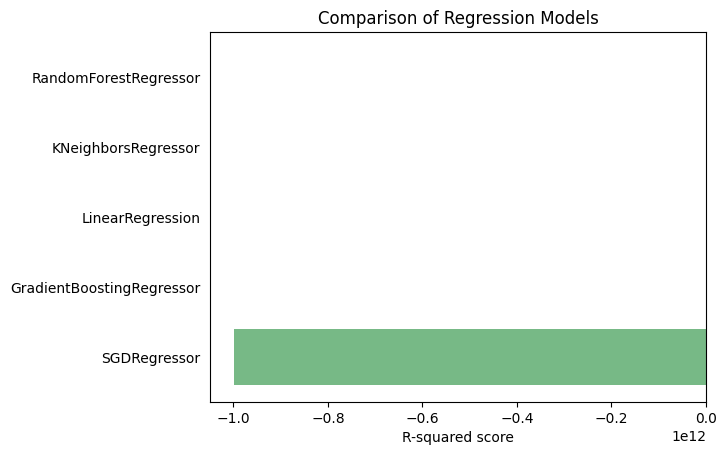

In [ ]:
# R2 score results
fig, ax = plt.subplots()
ind = range(len(results))
ax.barh(ind, list(results.values()), align='center',
        color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(results.keys())
ax.set_xlabel('R-squared score')
ax.tick_params(left=False, top=False, right=False)
ax.set_title('Comparison of Regression Models')
#fig.savefig('images/compare_models.png', bbox_inches = 'tight')

In [ ]:
# GradientBoosting will be used as the Mortality prediction model
reg_model = SGDRegressor(random_state = 0)
reg_model.fit(X_train, y_train)
y_test_preds = reg_model.predict(X_test)
r2_not_refined = r2_score(y_test, y_test_preds)
print("R2 score is: {:2f}".format(r2_not_refined))

R2 score is: -999485004185.716675


In [ ]:
# Target Variable = MortalityRate & Prediction Feature = other remaining variables in the table excluding 'LOS_ICU' as it has a very high score in feature selection
patient_survival = df_pat_adm_icu['PATIENT_SURVIVAL']

features_2 = df_pat_adm_icu.drop(columns = ['PATIENT_SURVIVAL', 'LOS_ICU'])

In [ ]:
# Testing and Training data set split: train 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(features_2,
                                                    patient_survival,
                                                    test_size = .20,
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))


Training set has 47504 samples.
Testing set has 11876 samples.


In [ ]:
# Regression models for comparison
models = [SGDRegressor(random_state = 0),
          GradientBoostingRegressor(random_state = 0),
          LinearRegression(),
          KNeighborsRegressor(),
          RandomForestRegressor(random_state = 0)]

results = {}

for model in models:

    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_train, y_train)

    # Make predictions with model
    y_test_preds = reg_model.predict(X_test)

   # Grab model name and store results associated with model
    name = str(model).split("(")[0]

    results[name] = r2_score(y_test, y_test_preds)
    print('{} done.'.format(name))

SGDRegressor done.
GradientBoostingRegressor done.
LinearRegression done.
KNeighborsRegressor done.
RandomForestRegressor done.


Text(0.5, 1.0, 'Comparison of Regression Models')

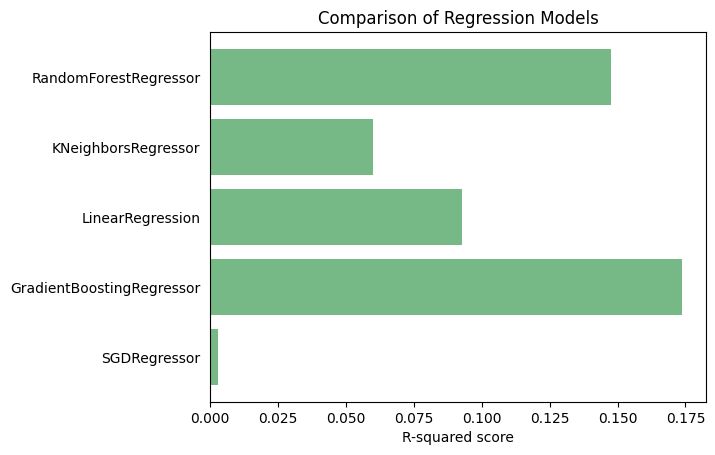

In [ ]:
# R2 score results
fig, ax = plt.subplots()
ind = range(len(results))
ax.barh(ind, list(results.values()), align='center',
        color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(results.keys())
ax.set_xlabel('R-squared score')
ax.tick_params(left=False, top=False, right=False)
ax.set_title('Comparison of Regression Models')
#fig.savefig('images/compare_models.png', bbox_inches = 'tight')

In [ ]:
# GradientBoosting will be used as the Mortality prediction model
reg_model = GradientBoostingRegressor(random_state = 0)
reg_model.fit(X_train, y_train)
y_test_preds = reg_model.predict(X_test)
r2_not_refined = r2_score(y_test, y_test_preds)
print("R2 score is: {:2f}".format(r2_not_refined))

R2 score is: 0.173846


In [ ]:
# Split into train 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(features_2,
                                                    patient_survival,
                                                    test_size = .20,
                                                    random_state = 42)

# Set the parameters by cross-validation
tuned_parameters = [{'n_estimators': [200, 300],
                     'max_depth' : [3, 4],
                     'loss': ['squared_error', 'absolute_error']}]

# create and fit a ridge regression model, testing each alpha
reg_model = GradientBoostingRegressor()
grid = GridSearchCV(reg_model, tuned_parameters)
grid.fit(X_train, y_train)
reg_model_optimized = grid.best_estimator_

# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_)

0.17464377773937206
GradientBoostingRegressor(max_depth=4, n_estimators=300)


In [ ]:
#reg_model = GradientBoostingRegressor(n_estimators = 200, max_depth=4, random_state=0)
#reg_model.fit(X_train, y_train)
y_test_preds = reg_model_optimized.predict(X_test)
r2_optimized = r2_score(y_test, y_test_preds)
print("Optimized R2 score is: {:2f}".format(r2_optimized))

Optimized R2 score is: 0.195177


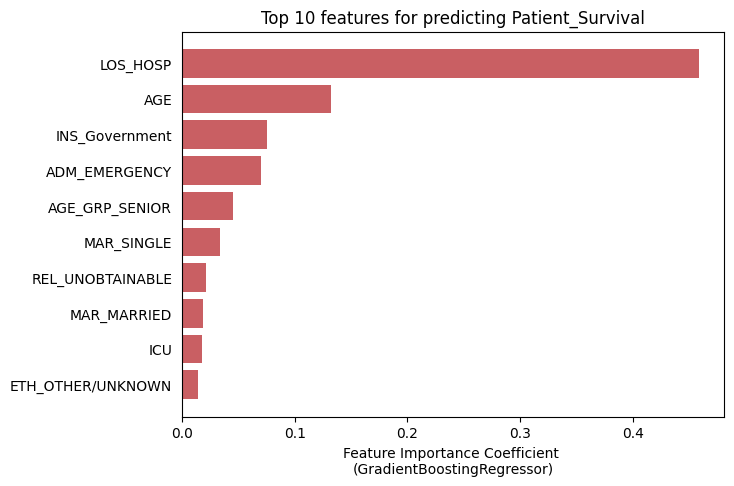

In [ ]:
# https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e
feature_imp = pd.DataFrame(reg_model_optimized.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_imp.head(10)


# Plot feature importance
fig, ax = plt.subplots(figsize=(7, 5))
ind = range(0,10)
ax.barh(ind, feature_imp['importance'].values[0:10],
        align='center', color='#c44e52', alpha=0.9)
ax.set_yticks(ind)
ax.set_yticklabels(feature_imp.index[0:10].tolist())
ax.tick_params(left=False, top=False, right=False)
ax.set_title("Top 10 features for predicting Patient_Survival")
ax.set_xlabel('Feature Importance Coefficient \n(GradientBoostingRegressor)')
plt.gca().invert_yaxis()
#fig.savefig('images/feature_importance.png', bbox_inches = 'tight')


In [ ]:
# RandomForestBoosting will be used as the Mortality prediction model
reg_model = RandomForestRegressor(random_state = 0)
reg_model.fit(X_train, y_train)
y_test_preds = reg_model.predict(X_test)
r2_not_refined = r2_score(y_test, y_test_preds)
print("R2 score is: {:2f}".format(r2_not_refined))

R2 score is: 0.151340


In [ ]:
# Split into train 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(features_2,
                                                    patient_survival,
                                                    test_size = .20,
                                                    random_state = 42)

# Set the parameters by cross-validation
tuned_parameters = [{'n_estimators': [200, 300, 400],
                     'max_depth' : [3, 4, 5]}]

# create and fit a ridge regression model, testing each alpha
reg_model = RandomForestRegressor()
grid = GridSearchCV(reg_model, tuned_parameters)
grid.fit(X_train, y_train)
reg_model_optimized = grid.best_estimator_

# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_)

0.13723029594252142
RandomForestRegressor(max_depth=5, n_estimators=300)


In [ ]:
y_test_preds = reg_model_optimized.predict(X_test)
r2_optimized = r2_score(y_test, y_test_preds)
print("Optimized R2 score is: {:2f}".format(r2_optimized))

Optimized R2 score is: 0.150150


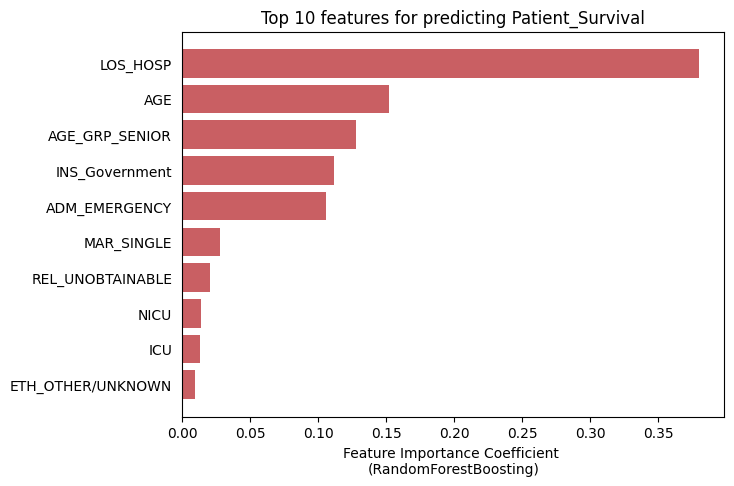

In [ ]:
# https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e
feature_imp = pd.DataFrame(reg_model_optimized.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_imp.head(10)


# Plot feature importance
fig, ax = plt.subplots(figsize=(7, 5))
ind = range(0,10)
ax.barh(ind, feature_imp['importance'].values[0:10],
        align='center', color='#c44e52', alpha=0.9)
ax.set_yticks(ind)
ax.set_yticklabels(feature_imp.index[0:10].tolist())
ax.tick_params(left=False, top=False, right=False)
ax.set_title("Top 10 features for predicting Patient_Survival")
ax.set_xlabel('Feature Importance Coefficient \n(RandomForestBoosting)')
plt.gca().invert_yaxis()
#fig.savefig('images/feature_importance.png', bbox_inches = 'tight')

## **Machine Learning Models (Other)**: XGBoost & Neural Networks

In [ ]:
# Testing and Training data set split: train 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(features_2,
                                                    patient_survival,
                                                    test_size = .20,
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 47504 samples.
Testing set has 11876 samples.


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(features, patient_survival, test_size=0.2, random_state=42)

In [ ]:
# Create and train the XGBoost model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:30:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'XGBoost Accuracy: {accuracy}')

XGBoost Accuracy: 0.9200909397103402


In [ ]:
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

R-squared: 0.11038986615580648


In [ ]:
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# One-hot encode the target variable
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
# Create and train the neural network
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=30, batch_size=8, verbose=1)

Epoch 1/30
5938/5938 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.8917 - loss: 0.2971
Epoch 2/30
5938/5938 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8992 - loss: 0.2710
Epoch 3/30
5938/5938 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9072 - loss: 0.2465
Epoch 4/30
5938/5938 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9073 - loss: 0.2427
Epoch 5/30
5938/5938 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9121 - loss: 0.2320
Epoch 6/30
5938/5938 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9104 - loss: 0.2337
Epoch 7/30
5938/5938 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.9094 - loss: 0.2336
Epoch 8/30
5938/5938 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.9108 - loss: 0.2336
Epoch 9/30
5938/5938 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9109 - loss: 0.2322
Epoch 10/30
5938/5938 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.9129 - loss: 0.2299
Epoch 11/30
5938/5938 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.9107 - loss: 0.2308
Epoch 12/30
5938/5938 ━━

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_pred)
print(f'Neural Network Accuracy: {accuracy}')

372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9116 - loss: 0.2336
Neural Network Accuracy: 0.9094812870025635
